# Brazil Transport Visualisation

## 0 - Imports

In [16]:
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
from shapely import LineString
from geopy.distance import geodesic
import numpy as np
import matplotlib.colors as mcolors

## I - Visualisation

In [17]:
import pandas as pd

# Sample GDP data with Portuguese state names
data = {
    'ADM1_PT': [
        'São Paulo', 'Rio de Janeiro', 'Minas Gerais', 'Rio Grande do Sul', 'Paraná',
        'Bahia', 'Santa Catarina', 'Distrito Federal', 'Pernambuco', 'Ceará',
        'Pará', 'Goiás', 'Amazonas', 'Espírito Santo', 'Mato Grosso',
        'Maranhão', 'Paraíba', 'Mato Grosso do Sul', 'Piauí', 'Rio Grande do Norte',
        'Alagoas', 'Sergipe', 'Rondônia', 'Tocantins', 'Acre',
        'Amapá', 'Roraima'
    ],
    'GDP_Billion_R$': [
        2720, 816, 788, 482, 484,
        312, 323, 254, 215, 162,
        187, 211, 150, 187, 141,
        98, 82, 123, 56, 73,
        66, 46, 52, 48, 16,
        15, 14
    ]
}

gdp_df = pd.DataFrame(data)


In [18]:

brazil_map = gpd.read_file("C:\\Datasets\\bra_adm_ibge_2020_shp\\bra_admbnda_adm1_ibge_2020.shp")
print(brazil_map.columns)

Index(['ADM0_EN', 'ADM0_PT', 'ADM0_PCODE', 'ADM1_PT', 'ADM1_PCODE',
       'geometry'],
      dtype='object')


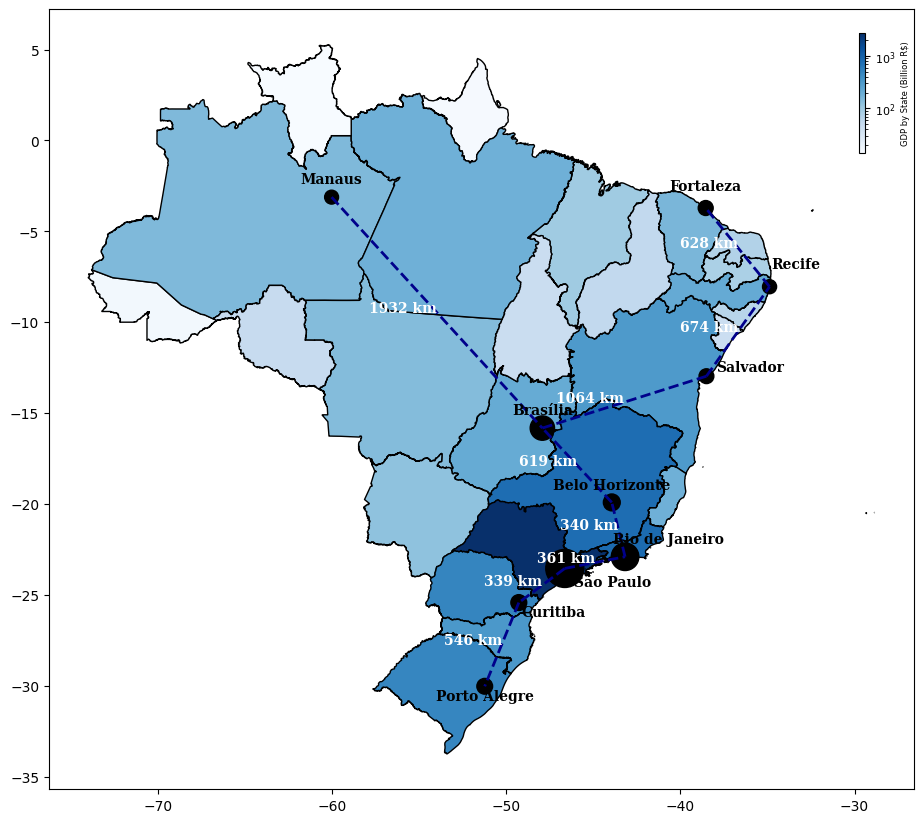

In [36]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import LineString
from geopy.distance import geodesic

# Data
cities = {
    "name": ["São Paulo", "Rio de Janeiro", "Belo Horizonte", "Brasília", "Salvador", "Recife", "Fortaleza", "Curitiba", "Porto Alegre", "Manaus"],
    "lat": [-23.5505, -22.9068, -19.9167, -15.8267, -12.9714, -8.0476, -3.7172, -25.4284, -30.0346, -3.1190],
    "lon": [-46.6333, -43.1729, -43.9345, -47.9218, -38.5014, -34.8770, -38.5433, -49.2733, -51.2300, -60.0217],
    "GDP": [699.28, 343.32, 97.28, 256.96, 63.57, 52.36, 65.68, 80.00, 78.12, 50.22] 
}

df_cities = pd.DataFrame(cities)
geo_cities = gpd.GeoDataFrame(df_cities, geometry=gpd.points_from_xy(df_cities["lon"], df_cities["lat"]), crs="EPSG:4326")

# Roads
roads = [
    ("São Paulo", "Rio de Janeiro"),
    ("Rio de Janeiro", "Belo Horizonte"),
    ("Belo Horizonte", "Brasília"),
    ("Brasília", "Salvador"),
    ("Salvador", "Recife"),
    ("Recife", "Fortaleza"),
    ("São Paulo", "Curitiba"),
    ("Curitiba", "Porto Alegre"),
    ("Manaus", "Brasília")
]

road_geometries = []
distances = []
for start, end in roads:
    start_point = geo_cities.loc[geo_cities["name"] == start, "geometry"].values[0]
    end_point = geo_cities.loc[geo_cities["name"] == end, "geometry"].values[0]
    road_geometries.append(LineString([start_point, end_point]))
    start_coords = (geo_cities.loc[geo_cities["name"] == start, "lat"].values[0],
                    geo_cities.loc[geo_cities["name"] == start, "lon"].values[0])
    end_coords = (geo_cities.loc[geo_cities["name"] == end, "lat"].values[0],
                  geo_cities.loc[geo_cities["name"] == end, "lon"].values[0])
    distances.append(geodesic(start_coords, end_coords).kilometers)

geo_roads = gpd.GeoDataFrame(pd.DataFrame(roads, columns=["start", "end"]), geometry=road_geometries, crs="EPSG:4326")
geo_roads["distance_km"] = distances

# Load Brazil map and color it in shades of blue
# brazil_map = gpd.read_file("C:\\Datasets\\ne_110m_admin_0_countries\\ne_110m_admin_0_countries.shp")
brazil_map = gpd.read_file("C:\\Datasets\\bra_adm_ibge_2020_shp\\bra_admbnda_adm1_ibge_2020.shp")
brazil_map = brazil_map.merge(gdp_df, on='ADM1_PT')
# brazil_map = brazil_map[brazil_map["ADMIN"] == "Brazil"]
brazil_map["log_GDP"] = np.log10(brazil_map["GDP_Billion_R$"])

norm = mcolors.LogNorm(vmin=brazil_map["GDP_Billion_R$"].min(), vmax=brazil_map["GDP_Billion_R$"].max())

fig, ax = plt.subplots(figsize=(12, 12))
sm = plt.cm.ScalarMappable(cmap="Blues", norm=norm)
sm._A = []  
cbar = fig.colorbar(sm, ax=ax, fraction=0.05, pad=0.02, shrink=1)  
cbar.set_label("GDP by State (Billion R$)", fontsize=6)
cbar.ax.tick_params(labelsize=8)

# Adjust legend position inside the map
cbar.ax.set_position([0.80, 0.7, 0.15, 0.1]) 
brazil_map.plot(
    ax=ax,
    column="GDP_Billion_R$",  
    cmap="Blues",
    edgecolor="black",
    norm=norm  
)

geo_roads.plot(ax=ax, color='darkblue', linewidth=2, linestyle='--')


# Scale city sizes by GDP (normalize for visualization)
city_sizes = (geo_cities["GDP"] / max(geo_cities["GDP"])) * 700 + 50

# Plot cities with size variation
geo_cities.plot(ax=ax, color='black', markersize=city_sizes)


OFFSET = 0.5
for x, y, label in zip(geo_cities.geometry.x, geo_cities.geometry.y, geo_cities.name):
    if label == 'Curitiba':
        ax.text(x + 4 * OFFSET, y - 1.5 * OFFSET, label, fontsize=10, ha='center', fontweight="bold", fontname='serif')
    elif label == 'Porto Alegre':
        ax.text(x, y - 1.5 * OFFSET, label, fontsize=10, ha='center', fontweight="bold", fontname='serif')
    elif label == 'São Paulo':
        ax.text(x + 5.5 * OFFSET, y - 2 * OFFSET, label, fontsize=10, ha='center', fontweight="bold", fontname='serif')
    elif label == 'Rio de Janeiro':
        ax.text(x + 5 * OFFSET, y + 1.5 * OFFSET, label, fontsize=10, ha='center', fontweight="bold", fontname='serif')
    elif label == 'Fortaleza':
        ax.text(x, y + 2 * OFFSET, label, fontsize=10, ha='center', fontweight="bold", fontname='serif')
    elif label == 'Recife':
        ax.text(x + 3 * OFFSET, y + 2 * OFFSET, label, fontsize=10, ha='center', fontweight="bold", fontname='serif')
    elif label == 'Salvador':
        ax.text(x + 5 * OFFSET, y + 0.5 * OFFSET, label, fontsize=10, ha='center', fontweight="bold", fontname='serif')
    else:
        ax.text(x, y + 1.5 * OFFSET, label, fontsize=10, ha='center', fontweight="bold", fontname='serif')


for i, row in geo_roads.iterrows():
    mid_x, mid_y = row.geometry.centroid.x, row.geometry.centroid.y
    ax.text(mid_x, mid_y, f"{row.distance_km:.0f} km", fontsize=10, color='white', ha='right', fontweight="bold", fontname='serif')

plt.show()